In [1]:
import pandas as pd
import numpy as np
import os
import sys
import polars as pl
import json
from joblib import Parallel, delayed
import deepchem
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import StratifiedGroupKFold, GroupKFold, KFold, GroupShuffleSplit, ShuffleSplit
import gc
import random
from functools import partial
import catboost
from catboost import FeaturesData, Pool, CatBoost, CatBoostClassifier, CatBoostRegressor, CatBoostRanker
import time
import math
from sklearn.metrics import average_precision_score
import sys
sys.path.append('../')
from src.utils.metrics import compute_metrics
from src.utils.misc import dict_as_table

# Configure Polars 
cfg = pl.Config()
cfg.set_tbl_rows(20)
cfg.set_tbl_cols(50)

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'dgl'
Skipped loading some Jax models, missing a dependency. No module named 'jax'
Skipped loading some PyTorch models, missing a dependency. No module named 'tensorflow'


polars.config.Config

In [2]:
DATA_DIR = '/home/dangnh36/datasets/competitions/leash_belka/'
FEATURE_DIR = '/home/dangnh36/datasets/competitions/leash_belka/processed/features/'
FEATURE_NAMES = ['ecfp6']
CV_STRATEGY = 'kf500'
CV_FOLD_IDX = 0
TRAIN_SUBSET = 'train'

PROTEINS = ['BRD4', 'HSA', 'sEH']
PRED_COLS = [f'pred_{col}' for col in PROTEINS]
TARGET_COLS = [f'target_{col}' for col in PROTEINS]

# Utils

In [3]:
_CUR_TIME = None
def log(*args, **kwargs):
    global _CUR_TIME
    if _CUR_TIME is None:
        print('Start logging time..')
        _CUR_TIME = time.time()
    else:
        cur_time = time.time()
        take = round(cur_time - _CUR_TIME, 2)
        _CUR_TIME = cur_time
        if len(args) > 0:
            print(f'[{take} s]', *args, **kwargs)

            
def evaluate(val_df, preds):
    val_df = val_df.copy()
    val_df[PRED_COLS] = preds
    metrics = compute_metrics(val_df)
    return metrics

## Load train-test split

In [4]:
TRAIN_LEN = 98_415_610
TEST_LEN = 878_022


def load_cv_split(data_dir, cv_strategy, cv_fold_idx, stage = 'train'):
    val_df = None
    idxs = None
    if 'kf' in cv_strategy:
        if stage == 'train':
            filter_cond = pl.col('fold_idx') != cv_fold_idx
        elif stage == 'val':
            filter_cond = pl.col('fold_idx') == cv_fold_idx
        val_df = pl.scan_csv(
            os.path.join(data_dir, 'processed', 'cv', cv_strategy,
                         'cv.csv')).filter(filter_cond).select(
                             pl.col('index'), subset=pl.lit(3).cast(pl.UInt8)).collect().to_pandas()
        idxs = val_df['index'].to_numpy()
    else:
        if stage == 'train':
#             if cv_fold_idx == 611:
#                 raise NotImplementedError
#                 idxs = np.arange(0, len(features))
#             else:
#                 idxs = pl.scan_csv(
#                     os.path.join(
#                         data_dir, 'processed', 'cv', cv_strategy,
#                         'train.csv')).select(pl.col(
#                             'index')).collect().to_numpy().flatten()

            val_df = pl.scan_csv(
                os.path.join(data_dir, 'processed', 'cv', cv_strategy,
                             'val.csv')).filter(pl.col('subset').is_in([2, 3])).select(
                                 pl.col('index'),
                                 pl.col('subset').cast(
                                     pl.UInt8)).collect().to_pandas()
            val_idxs = val_df['index'].to_numpy()
            idxs = np.array(sorted(list(set(range(TRAIN_LEN)).difference(set(val_idxs)))))
            val_df = None
        elif stage == 'val':
            val_df = pl.scan_csv(
                os.path.join(data_dir, 'processed', 'cv', cv_strategy,
                             'val.csv')).filter(pl.col('subset').is_in([2, 3])).select(
                                 pl.col('index'),
                                 pl.col('subset').cast(
                                     pl.UInt8)).collect().to_pandas()
            idxs = val_df['index'].to_numpy()
        else:
            raise AssertionError
    return val_df, idxs

In [5]:
val_df, val_idxs = load_cv_split(DATA_DIR, CV_STRATEGY, CV_FOLD_IDX, 'val')

if TRAIN_SUBSET == 'train': 
    train_df, train_idxs = load_cv_split(DATA_DIR, CV_STRATEGY, CV_FOLD_IDX, 'train')
else:
    # subset only
    train_df = None
    train_idxs = pl.scan_csv('/home/dangnh36/datasets/competitions/leash_belka/processed/cv/train_5_7.8M_idxs.csv').\
        collect()['index'].to_numpy()

val_df.shape, val_idxs.shape, train_df, train_idxs.shape if train_idxs is not None else None

((196832, 2),
 (196832,),
              index  subset
 0                0       3
 1                1       3
 2                2       3
 3                3       3
 4                4       3
 ...            ...     ...
 98218773  98415605       3
 98218774  98415606       3
 98218775  98415607       3
 98218776  98415608       3
 98218777  98415609       3
 
 [98218778 rows x 2 columns],
 (98218778,))

In [6]:
193994 + 98221616 == TRAIN_LEN

True

# Load data into RAM

#### RDKit Descriptor

In [7]:
def unpackbits_hook(features):
    features = np.unpackbits(features, axis = -1)
    return features    


In [8]:
FEATURE_META = {
    'ecfp6': {
        # must ignore after unpackbits
#         'ignore_cols': [39, 378, 397, 450, 650, 807, 1152, 1182, 1184, 1201, 1350, 1380, 1582, 1621, 1855, 1917, 1967, 2007],
        'ignore_cols': [],
        'process_hook': unpackbits_hook,
        'debug': False
    },
    'rdkit210':{
        'ignore_cols': [10, 69, 82, 125, 157, 158, 160, 162, 163, 164, 168, 170, 174, 175, 178, 186, 192, 193, 197, 199, 206],
        'process_hook': None,
        'debug': True
    }
}

In [9]:
class Feature:
    def __init__(self, feature, ignore_cols = [], process_hook = None):
        self._feature = feature
        self.num_rows, self.num_cols = feature.shape
        self.ignore_cols = ignore_cols
        self.keep_cols = sorted(list(set(range(self.num_cols)).difference(set(self.ignore_cols))))
        self.process_hook = process_hook
        
    @property
    def shape(self):
        return self._feature.shape
        
    def load(self, idxs):
        ret = self._feature[np.ix_(idxs, self.keep_cols)]
        if self.process_hook is not None:
            ret = self.process_hook(ret)
        return ret

    
def load_features(feature_dir, feature_names, split = 'train', backend = 'mmap'):
    all_features = []
    meta = {}
    for feature_name in feature_names:        
        if backend == 'mmap':
            print(f'Loadding feature {feature_name} with backend {backend}')
            fname = os.path.join(feature_dir, feature_name, f'{split}.npy')
            feat = np.load(fname, mmap_mode='r')
            feat = Feature(feat,
                           ignore_cols = FEATURE_META[feature_name]['ignore_cols'],
                           process_hook = FEATURE_META[feature_name]['process_hook'],
                          )
        else:
            raise NotImplementedError
        all_features.append(feat)
    return all_features


def combine_features(all_features, idxs):
    features = [feat.load(idxs) for feat in all_features]
    features = np.concatenate(features, axis = -1, dtype = np.float32) \
        if len(features) > 1 else features[0].astype(np.float32)
    return features

In [10]:
all_features = load_features(FEATURE_DIR, FEATURE_NAMES, split = 'train', backend = 'mmap')
[(type(feat), feat.shape) for feat in all_features]

Loadding feature ecfp6 with backend mmap


[(__main__.Feature, (98415610, 256))]

In [11]:
all_targets = pl.scan_csv(os.path.join(DATA_DIR, 'processed', 'train_v2.csv')).select(
    pl.col('BRD4', 'HSA', 'sEH').cast(pl.UInt8), ).collect().to_numpy()
all_targets.shape

(98415610, 3)

In [12]:
print('NUM POSITIVES:', np.where(all_targets.any(axis = -1))[0].shape)
print('NUM NEGATIVES:', np.where(np.logical_not(all_targets.any(axis = -1)))[0].shape)

NUM POSITIVES: (1509779,)
NUM NEGATIVES: (96905831,)


# Split data into chunks for training (reproduce?)

In [13]:
class RandomSampler:
    """This ensure every elements in arr will be sampled
    """
    def __init__(self, arr):
        self.arr = arr
        self._len = len(arr)
        self.pool = np.random.permutation(arr).tolist()
        self.cover_all = False

    def next(self, n):
        while len(self.pool) < n:
            self.pool.extend(np.random.permutation(self.arr))
            self.cover_all = True
        ret = self.pool[:n]
        self.pool = self.pool[n:]
        return ret


def split_to_chunks(train_idxs, all_targets, neg_pos_ratio = 5.0, pos_per_chunk_fraction = 1.0, num_chunks = -1, random_state = 42):
    train_targets = all_targets[train_idxs]
    train_pos_idxs = train_idxs[np.where(train_targets.any(axis = -1))[0]]
    train_neg_idxs = train_idxs[np.where(np.logical_not(train_targets.any(axis = -1)))[0]]
    num_pos = len(train_pos_idxs)
    num_neg = len(train_neg_idxs)
    print(f'[TOTAL] pos={num_pos} neg={num_neg} neg/pos={num_neg/num_pos}')

    # shuffle both
    np.random.seed(random_state)
    np.random.shuffle(train_pos_idxs)
    np.random.shuffle(train_neg_idxs)

    chunk_pos_idxs_generator = RandomSampler(train_pos_idxs)
    chunk_neg_idxs_generator = RandomSampler(train_neg_idxs)

    cur_chunk_idx = -1
    while True:
        cur_chunk_idx += 1
        if (num_chunks > 0 and cur_chunk_idx > num_chunks -1) or \
            (num_chunks <= 0 and (chunk_pos_idxs_generator.cover_all and chunk_neg_idxs_generator.cover_all)):
            break
        
        chunk_num_pos = int(num_pos * pos_per_chunk_fraction)
        chunk_num_neg = int(chunk_num_pos * neg_pos_ratio)
        chunk_pos_idxs = chunk_pos_idxs_generator.next(chunk_num_pos)
        chunk_neg_idxs = chunk_neg_idxs_generator.next(chunk_num_neg)
        yield chunk_pos_idxs, chunk_neg_idxs

    print('ALL DONE!')
    del chunk_pos_idxs_generator, chunk_neg_idxs_generator
    gc.collect()

In [14]:
# Testing purpose
if 0:
    chunks_iter = split_to_chunks(train_idxs=train_idxs,
                                  all_targets = all_targets,
                                  neg_pos_ratio = 5.0,
                                 pos_per_chunk_fraction=0.5,
                                 num_chunks=-1)
    
    for chunk_idx, (chunk_pos_idxs, chunk_neg_idxs) in enumerate(chunks_iter):
        print(f'chunk={chunk_idx} pos={len(chunk_pos_idxs)} neg={len(chunk_neg_idxs)}')

In [15]:
CBM_DEFAULT_PARAMS = dict(
    # Common settings
    loss_function='MultiLogloss',
    custom_metric=None,
    eval_metric=None,
    iterations=None,
    learning_rate=None,
    random_state=42,
    l2_leaf_reg=None,
    bootstrap_type=None,
    bagging_temperature=None,
    subsample=None,
    sampling_frequency=None,  # PerTreeLevel | PerTree
    sampling_unit=None,  # Object | Group
    mvs_reg = None,
    random_strength=None,
    use_best_model = True,
    best_model_min_trees = None,
    max_depth = None,   # default = 6 | 16 if Lossguide
    grow_policy = 'SymmetricTree',
    min_data_in_leaf = None,
    max_leaves = None,  # default = 31, Lossguide only
    ignored_features = None,  # a list
    one_hot_max_size = None,  # default to 2 usually
    has_time = False,
    rsm = None, # default = 1
    nan_mode = 'Forbidden',
    input_borders = None,   # should set
    output_borders = None,  # should set
    fold_permutation_block = None,  # default 1
    leaf_estimation_method = None,
    leaf_estimation_iterations = None,
    leaf_estimation_backtracking = None, # AnyImprovement
    fold_len_multiplier = None, # default 2
    approx_on_full_history = None,  # default False -> faster but may less accurate
    class_weights = None,   # list | dict | OrderedDict
    classes_count = None,
    class_names = None, # list of str
    auto_class_weights = None, # None | Balanced | SqrtBalanced
    scale_pos_weight = None,
    boosting_type = None, # Ordered | Plain
    boost_from_average = None,
    langevin = None, # default False
    diffusion_temperature = None,
    posterior_sampling = None, # default False
    allow_const_label = False,
    score_function = None, # Cosine | L2 | NewtonCosine | NewtonL2
    monotone_constraints = None, # prior knownledge
    feature_weights = None, # prior knownledge or obtained from feature importance
    first_feature_use_penalties = None, # ?
    fixed_binary_splits = None, # ?
    penalties_coefficient = None, # default 1
    per_object_feature_penalties = None, # ?
    model_shrink_rate = None, # ?
    model_shrink_mode = None, # ?
    # CTR Settings
    simple_ctr = None,
    combinations_ctr = None,
    per_feature_ctr = None,
    ctr_target_border_count = None,
    counter_calc_method = None, # SkipTest | Full
    max_ctr_complexity = None,  # default 4, 1 if multiclass
    ctr_leaf_count_limit = None, # default to no limit
    store_all_simple_ctr = None,
    final_ctr_computation_mode = None,
    # Output Settings
    logging_level = 'Verbose',
    metric_period = 100,
    train_dir = 'runs/catboost/',
    model_size_reg = None,  # default to 0.5, could try to turn off
    allow_writing_files = True,
    save_snapshot = True, # not supported in cv, should be disable when grid search
    snapshot_file = None, # dangerous!
    snapshot_interval = 600,
    # roc_file = None,

    
    # UNK UNK UNK !!!   
    border_count=None,
    feature_border_type=None,
    per_float_feature_quantization=None,
    od_pval=None,
    od_wait=None,
    od_type=None,
    thread_count=None,
    name=None,
    custom_loss=None,
    used_ram_limit=None,
    gpu_ram_part=None,
    task_type=None,
    device_config=None,
    devices=None,
    dev_score_calc_obj_block_size=None,
    reg_lambda=None,
    eta=None,
    max_bin=None,
    gpu_cat_features_storage=None,
    data_partition=None,
    metadata=None,
    early_stopping_rounds=None,
    cat_features=None,
    ctr_history_unit=None,
    text_features=None,
    tokenizers=None,
    dictionaries=None,
    feature_calcers=None,
    text_processing=None,
)

# CBM_DEFAULT_PARAMS = dict()

# Train

In [16]:
log()
val_features = combine_features(all_features, val_idxs)
val_targets = all_targets[val_idxs]

val_df[TARGET_COLS] = val_targets
val_df

log(f'Val features: {val_features.shape} {val_features.dtype}')

val_pool = Pool(
       data = val_features,
       label = val_targets,
       cat_features=None,
       weight=None,
       baseline=None,
       feature_names=None,
       thread_count=-1
    )
log(f'Val pool: {val_pool.num_row()} x {val_pool.num_col()}')

Start logging time..
[80.53 s] Val features: (196832, 2048) float32
[0.56 s] Val pool: 196832 x 2048


In [29]:
chunks_iter = split_to_chunks(train_idxs=train_idxs,
                              all_targets = all_targets,
                              neg_pos_ratio = 5.0,
                              pos_per_chunk_fraction=1.0,
                              num_chunks=-1)
# chunks_iter = list(chunks_iter)
# for chunk_idx, (chunk_pos_idxs, chunk_neg_idxs) in enumerate(chunks_iter):
#     print(chunk_idx, len(chunk_pos_idxs), len(chunk_neg_idxs))

In [18]:
# chunk_pos_idxs = chunks_iter[0][0]
# chunk_neg_idxs = chunks_iter[0][1]
# tmp_df = pl.DataFrame({
#     'index': chunk_pos_idxs + chunk_neg_idxs
# })
# tmp_df

In [19]:
# len = 7_812_348
# tmp_df.write_csv('/home/dangnh36/datasets/competitions/leash_belka/processed/train_5_7.8M.csv')

In [23]:
def validate(model, val_pool, val_df):
    ##### EVALUATION #####

    metric_names = ['share_AP', 'share_micro_AP', 'share_BRD4_AP', 'share_HSA_AP', 'share_sEH_AP']
    all_scores = []
    for ntree_end in list(range(0, model.get_best_iteration(), 500)) + [model.get_best_iteration()]:
        print(f'\n\n------------{ntree_end}-----------')
        preds = model.predict_proba(val_pool,
                                    ntree_start = 0,
                                    ntree_end = ntree_end + 1,
                                    verbose = 100)
        preds.shape
        metrics = evaluate(val_df, preds)

        # micro AP
        gts = val_df[TARGET_COLS].to_numpy().flatten()
        preds = preds.flatten()
        metrics['share_micro_AP'] = average_precision_score(gts, preds)

        _scores = [str(round(ntree_end / 1000, 1))] + [str(round(metrics[k] * 100, 4)) for k in metric_names]
        all_scores.append(_scores)
        print('	'.join(_scores))

    print('------------FINAL RESULTS---------------\n')
    print('	'.join(['iterations'] + metric_names))
    for scores in all_scores:
        print('	'.join(scores))
        
    return metrics

In [21]:
# !rm -r runs/catboost/

In [30]:
SAVE_ROOT_DIR = './runs/catboost/v0'


for chunk_idx, (chunk_pos_idxs, chunk_neg_idxs) in enumerate(chunks_iter):
    if chunk_idx <= 1:
        continue
    print('##################################################')
    log(f'[TRAINING] chunk={chunk_idx} pos={len(chunk_pos_idxs)} neg={len(chunk_neg_idxs)}')
    
    print('Loading train features..')
    chunk_idxs = chunk_pos_idxs + chunk_neg_idxs
#     train_features = all_features[chunk_idxs]
    train_features = combine_features(all_features, chunk_idxs)
    train_targets = all_targets[chunk_idxs]
    log(f'Filter {train_features.shape} {train_targets.shape}')
    
#     train_features = np.unpackbits(train_features, axis = -1)
#     train_features = train_features.astype(np.float32)

    log(f'Unpacked {train_features.shape}')

    train_pool = Pool(
       data = train_features,
       label = train_targets,
       cat_features=None,
       weight=None,
       baseline=None,
       feature_names=None,
       thread_count=-1
    )
    log(f'Train pool: {train_pool.num_row()} x {train_pool.num_col()}')
    del train_features, train_targets, chunk_idxs
    gc.collect()

    CHUNK_SAVE_DIR = os.path.join(SAVE_ROOT_DIR, f'chunk_{chunk_idx}')
    os.makedirs(CHUNK_SAVE_DIR, exist_ok=True)
    updated_params = dict(
        task_type='GPU',
        devices='0:2:3',
        # loss_function = 'MultiCrossEntropy',
        loss_function = 'MultiLogloss',
        iterations = 4500,
        learning_rate = 0.2,
        random_state = 42,
        train_dir = CHUNK_SAVE_DIR,
        # max_ctr_complexity = 1,
        depth = 10,
        min_data_in_leaf = 2,
#         colsample_bylevel = 0.3,
        bootstrap_type = 'No',
#         mvs_reg = 10,
#         subsample = 0.3,
#         thread_count = 80,
        # auto_class_weights='Balanced',
        # scale_pos_weight = 1.2,
        # class_weights=[2.0, 1.0],
        # used_ram_limit = '180GB',
        gpu_ram_part = 0.75,
        # gpu_cat_features_storage = 'CpuPinnedMemory',
        early_stopping_rounds = 1000,

#         border_count = 2, # binary features
#         feature_border_type = 'Uniform',
    )

    params = CBM_DEFAULT_PARAMS.copy()
    params.update(updated_params)
    model = CatBoostClassifier(
        **params
    )
    print(model.get_params())
    model.fit(
        train_pool,
        verbose=100,
        eval_set=val_pool,
        plot = True
    )
    print('ALL PARAMS:\n', model.get_all_params())
    
    
    # SAVE & LOAD MODEL
    with open(os.path.join(CHUNK_SAVE_DIR, 'all_params.json'), 'w') as f:
        json.dump(model.get_all_params(), f)
        
    model_save_path = os.path.join(CHUNK_SAVE_DIR, 'model.cbm')
    model.save_model(model_save_path,
           format="cbm",
           export_parameters=None,
           pool=None)
    
    model = CatBoostClassifier()
    model.load_model(model_save_path)
    
    metrics = validate(model, val_pool, val_df)
    print(f'METRICS AT CHUNK={chunk_idx}:\n{metrics}')
    print('\n\n\n\n\n')
    
    del train_pool
    gc.collect()

[TOTAL] pos=1506745 neg=96712033 neg/pos=64.18606532624963
##################################################
[1888.66 s] [TRAINING] chunk=2 pos=1506745 neg=7533725
Loading train features..
[437.58 s] Filter (9040470, 2048) (9040470, 3)
[0.0 s] Unpacked (9040470, 2048)
[18.13 s] Train pool: 9040470 x 2048
{'iterations': 4500, 'learning_rate': 0.2, 'depth': 10, 'loss_function': 'MultiLogloss', 'nan_mode': 'Forbidden', 'use_best_model': True, 'logging_level': 'Verbose', 'metric_period': 100, 'has_time': False, 'allow_const_label': False, 'train_dir': './runs/catboost/v0/chunk_2', 'save_snapshot': True, 'snapshot_interval': 600, 'gpu_ram_part': 0.75, 'allow_writing_files': True, 'task_type': 'GPU', 'devices': '0:2:3', 'bootstrap_type': 'No', 'random_state': 42, 'early_stopping_rounds': 1000, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 2}


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.4153482	test: 0.4025799	best: 0.4025799 (0)	total: 354ms	remaining: 26m 31s
100:	learn: 0.0835064	test: 0.0341570	best: 0.0341570 (100)	total: 19.9s	remaining: 14m 25s
200:	learn: 0.0740557	test: 0.0305418	best: 0.0305418 (200)	total: 43.4s	remaining: 15m 27s
300:	learn: 0.0695852	test: 0.0287418	best: 0.0287418 (300)	total: 1m 6s	remaining: 15m 20s
400:	learn: 0.0667407	test: 0.0275754	best: 0.0275754 (400)	total: 1m 29s	remaining: 15m 10s
500:	learn: 0.0646658	test: 0.0267871	best: 0.0267871 (500)	total: 1m 52s	remaining: 14m 55s
600:	learn: 0.0630426	test: 0.0261770	best: 0.0261770 (600)	total: 2m 12s	remaining: 14m 21s
700:	learn: 0.0617502	test: 0.0257430	best: 0.0257430 (700)	total: 2m 32s	remaining: 13m 48s
800:	learn: 0.0605874	test: 0.0253713	best: 0.0253713 (800)	total: 2m 52s	remaining: 13m 16s
900:	learn: 0.0596113	test: 0.0250950	best: 0.0250950 (900)	total: 3m 11s	remaining: 12m 45s
1000:	learn: 0.0587631	test: 0.0248552	best: 0.0248552 (1000)	total: 3m 30s	re

[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


0.0	19.3698	26.1738	9.4528	4.6356	44.0211


------------500-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


0.5	54.4919	59.2764	54.9355	32.6577	75.8827


------------1000-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


1.0	58.0472	62.9881	58.7119	35.1988	80.2308


------------1500-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


1.5	59.1145	64.1481	60.2985	35.5068	81.5381


------------2000-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


2.0	59.4783	64.5777	60.9517	35.423	82.0602


------------2500-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


2.5	59.6573	64.8385	61.1967	35.3551	82.4202


------------3000-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


3.0	59.7279	64.9458	61.3648	35.1878	82.6312


------------3500-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


3.5	59.8474	65.0568	61.6457	35.1572	82.7391


------------4000-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


4.0	59.8784	65.1011	61.8097	34.9938	82.8316


------------4499-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


4.5	59.9283	65.1734	61.897	34.9217	82.966
------------FINAL RESULTS---------------

iterations	share_AP	share_micro_AP	share_BRD4_AP	share_HSA_AP	share_sEH_AP
0.0	19.3698	26.1738	9.4528	4.6356	44.0211
0.5	54.4919	59.2764	54.9355	32.6577	75.8827
1.0	58.0472	62.9881	58.7119	35.1988	80.2308
1.5	59.1145	64.1481	60.2985	35.5068	81.5381
2.0	59.4783	64.5777	60.9517	35.423	82.0602
2.5	59.6573	64.8385	61.1967	35.3551	82.4202
3.0	59.7279	64.9458	61.3648	35.1878	82.6312
3.5	59.8474	65.0568	61.6457	35.1572	82.7391
4.0	59.8784	65.1011	61.8097	34.9938	82.8316
4.5	59.9283	65.1734	61.897	34.9217	82.966
METRICS AT CHUNK=2:
{'share_BRD4_AP': 0.6189703593664793, 'share_HSA_AP': 0.3492172469165442, 'share_sEH_AP': 0.8296599834037583, 'share2_BRD4_AP': 0.6189703593664793, 'share2_HSA_AP': 0.3492172469165442, 'share2_sEH_AP': 0.8296599834037583, 'pseudo_AP': 0.5992825298955939, 'AP': 0.5992825298955939, 'share_AP': 0.5992825298955939, 'share2_AP': 0.5992825298955939, 'share_micro_AP': 0.6517340425594744}




MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.4153450	test: 0.4025774	best: 0.4025774 (0)	total: 317ms	remaining: 23m 48s
100:	learn: 0.0833056	test: 0.0341697	best: 0.0341697 (100)	total: 18.9s	remaining: 13m 44s
200:	learn: 0.0739044	test: 0.0305166	best: 0.0305166 (200)	total: 38s	remaining: 13m 32s
300:	learn: 0.0694560	test: 0.0287237	best: 0.0287237 (300)	total: 57s	remaining: 13m 15s
400:	learn: 0.0666969	test: 0.0275864	best: 0.0275864 (400)	total: 1m 15s	remaining: 12m 55s
500:	learn: 0.0645912	test: 0.0267597	best: 0.0267597 (500)	total: 1m 35s	remaining: 12m 40s
600:	learn: 0.0629712	test: 0.0261534	best: 0.0261534 (600)	total: 1m 54s	remaining: 12m 22s
700:	learn: 0.0617189	test: 0.0257330	best: 0.0257330 (700)	total: 2m 13s	remaining: 12m 3s
800:	learn: 0.0605839	test: 0.0253688	best: 0.0253688 (800)	total: 2m 32s	remaining: 11m 45s
900:	learn: 0.0596064	test: 0.0250913	best: 0.0250913 (900)	total: 2m 51s	remaining: 11m 26s
1000:	learn: 0.0587243	test: 0.0248508	best: 0.0248508 (1000)	total: 3m 11s	remaini

[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


0.0	19.4345	26.2375	9.4669	4.7554	44.0811


------------500-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


0.5	54.5334	59.2967	54.1388	32.9817	76.4798


------------1000-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


1.0	57.9785	62.9624	58.2907	35.0731	80.5718


------------1500-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


1.5	59.1553	64.1792	59.8591	35.6947	81.9121


------------2000-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


2.0	59.6436	64.6588	60.3978	36.0649	82.4681


------------2500-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


2.5	59.8903	64.9924	60.9188	35.8951	82.8571


------------3000-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


3.0	59.9933	65.1742	61.2836	35.5851	83.1113


------------3500-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


3.5	60.1196	65.2864	61.592	35.5736	83.1932


------------4000-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


4.0	60.204	65.3984	61.7387	35.5481	83.3251


------------4484-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


4.5	60.1809	65.374	61.8127	35.4294	83.3007
------------FINAL RESULTS---------------

iterations	share_AP	share_micro_AP	share_BRD4_AP	share_HSA_AP	share_sEH_AP
0.0	19.4345	26.2375	9.4669	4.7554	44.0811
0.5	54.5334	59.2967	54.1388	32.9817	76.4798
1.0	57.9785	62.9624	58.2907	35.0731	80.5718
1.5	59.1553	64.1792	59.8591	35.6947	81.9121
2.0	59.6436	64.6588	60.3978	36.0649	82.4681
2.5	59.8903	64.9924	60.9188	35.8951	82.8571
3.0	59.9933	65.1742	61.2836	35.5851	83.1113
3.5	60.1196	65.2864	61.592	35.5736	83.1932
4.0	60.204	65.3984	61.7387	35.5481	83.3251
4.5	60.1809	65.374	61.8127	35.4294	83.3007
METRICS AT CHUNK=3:
{'share_BRD4_AP': 0.6181266769944002, 'share_HSA_AP': 0.35429415858842894, 'share_sEH_AP': 0.8330074306253765, 'share2_BRD4_AP': 0.6181266769944002, 'share2_HSA_AP': 0.35429415858842894, 'share2_sEH_AP': 0.8330074306253765, 'pseudo_AP': 0.6018094220694019, 'AP': 0.6018094220694019, 'share_AP': 0.6018094220694019, 'share2_AP': 0.6018094220694019, 'share_micro_AP': 0.6537399020820095}

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.4153601	test: 0.4025781	best: 0.4025781 (0)	total: 310ms	remaining: 23m 13s
100:	learn: 0.0833489	test: 0.0342409	best: 0.0342409 (100)	total: 18.7s	remaining: 13m 36s
200:	learn: 0.0740203	test: 0.0306751	best: 0.0306751 (200)	total: 37.6s	remaining: 13m 24s
300:	learn: 0.0694601	test: 0.0287325	best: 0.0287325 (300)	total: 56.5s	remaining: 13m 8s
400:	learn: 0.0666761	test: 0.0276077	best: 0.0276077 (400)	total: 1m 15s	remaining: 12m 52s
500:	learn: 0.0646247	test: 0.0268179	best: 0.0268179 (500)	total: 1m 34s	remaining: 12m 35s
600:	learn: 0.0630382	test: 0.0262565	best: 0.0262565 (600)	total: 1m 53s	remaining: 12m 17s
700:	learn: 0.0617036	test: 0.0258177	best: 0.0258177 (700)	total: 2m 13s	remaining: 12m
800:	learn: 0.0605896	test: 0.0254800	best: 0.0254800 (800)	total: 2m 32s	remaining: 11m 43s
900:	learn: 0.0596023	test: 0.0251877	best: 0.0251877 (900)	total: 2m 51s	remaining: 11m 25s
1000:	learn: 0.0587240	test: 0.0249752	best: 0.0249752 (1000)	total: 3m 10s	remaini

[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


0.0	19.14	25.9074	9.4496	4.6008	43.3698


------------500-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


0.5	54.2242	59.1294	54.4353	31.9849	76.2525


------------1000-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


1.0	57.5401	62.6878	58.1497	34.0427	80.428


------------1500-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


1.5	58.7647	63.8994	59.7194	34.8646	81.7101


------------2000-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


2.0	59.106	64.346	60.3181	34.7183	82.2816


------------2500-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


2.5	59.4224	64.6586	60.8301	34.8912	82.5457


------------3000-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


3.0	59.5869	64.8086	61.2587	34.8771	82.6249


------------3500-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


3.5	59.6574	64.8863	61.4381	34.8363	82.6979


------------4000-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


4.0	59.6739	64.8616	61.4899	34.8865	82.6452


------------4495-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


4.5	59.6689	64.9026	61.5211	34.7118	82.7737
------------FINAL RESULTS---------------

iterations	share_AP	share_micro_AP	share_BRD4_AP	share_HSA_AP	share_sEH_AP
0.0	19.14	25.9074	9.4496	4.6008	43.3698
0.5	54.2242	59.1294	54.4353	31.9849	76.2525
1.0	57.5401	62.6878	58.1497	34.0427	80.428
1.5	58.7647	63.8994	59.7194	34.8646	81.7101
2.0	59.106	64.346	60.3181	34.7183	82.2816
2.5	59.4224	64.6586	60.8301	34.8912	82.5457
3.0	59.5869	64.8086	61.2587	34.8771	82.6249
3.5	59.6574	64.8863	61.4381	34.8363	82.6979
4.0	59.6739	64.8616	61.4899	34.8865	82.6452
4.5	59.6689	64.9026	61.5211	34.7118	82.7737
METRICS AT CHUNK=4:
{'share_BRD4_AP': 0.6152113453246663, 'share_HSA_AP': 0.34711818312919845, 'share_sEH_AP': 0.8277372437367303, 'share2_BRD4_AP': 0.6152113453246663, 'share2_HSA_AP': 0.34711818312919845, 'share2_sEH_AP': 0.8277372437367303, 'pseudo_AP': 0.5966889240635317, 'AP': 0.5966889240635317, 'share_AP': 0.5966889240635317, 'share2_AP': 0.5966889240635317, 'share_micro_AP': 0.6490256503150351}


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.4153509	test: 0.4025768	best: 0.4025768 (0)	total: 283ms	remaining: 21m 14s
100:	learn: 0.0828093	test: 0.0338670	best: 0.0338670 (100)	total: 18.9s	remaining: 13m 45s
200:	learn: 0.0738647	test: 0.0304745	best: 0.0304745 (200)	total: 37.6s	remaining: 13m 24s
300:	learn: 0.0693688	test: 0.0286154	best: 0.0286154 (300)	total: 56.6s	remaining: 13m 9s
400:	learn: 0.0664809	test: 0.0274584	best: 0.0274584 (400)	total: 1m 15s	remaining: 12m 53s
500:	learn: 0.0644948	test: 0.0266985	best: 0.0266985 (500)	total: 1m 34s	remaining: 12m 37s
600:	learn: 0.0629167	test: 0.0261211	best: 0.0261211 (600)	total: 1m 54s	remaining: 12m 21s
700:	learn: 0.0615979	test: 0.0256724	best: 0.0256724 (700)	total: 2m 13s	remaining: 12m 2s
800:	learn: 0.0604618	test: 0.0253372	best: 0.0253372 (800)	total: 2m 32s	remaining: 11m 44s
900:	learn: 0.0595130	test: 0.0250863	best: 0.0250863 (900)	total: 2m 51s	remaining: 11m 26s
1000:	learn: 0.0586462	test: 0.0248569	best: 0.0248569 (1000)	total: 3m 11s	rema

[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


0.0	19.1557	25.9062	9.4365	4.5967	43.4338


------------500-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


0.5	54.8176	59.5137	54.6269	33.4151	76.4108


------------1000-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


1.0	57.9543	62.8501	58.3423	35.3172	80.2033


------------1500-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


1.5	59.0279	63.9938	59.9093	35.7562	81.4183


------------2000-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


2.0	59.4353	64.4207	60.4839	35.8563	81.9656


------------2500-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


2.5	59.5512	64.6131	60.7554	35.6332	82.265


------------3000-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


3.0	59.8055	64.8694	61.1853	35.7297	82.5013


------------3500-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


3.5	59.8711	64.9905	61.2055	35.6803	82.7275


------------4000-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


4.0	60.015	65.0922	61.3586	35.8703	82.8161


------------4496-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


4.5	60.0191	65.1751	61.4459	35.6408	82.9706
------------FINAL RESULTS---------------

iterations	share_AP	share_micro_AP	share_BRD4_AP	share_HSA_AP	share_sEH_AP
0.0	19.1557	25.9062	9.4365	4.5967	43.4338
0.5	54.8176	59.5137	54.6269	33.4151	76.4108
1.0	57.9543	62.8501	58.3423	35.3172	80.2033
1.5	59.0279	63.9938	59.9093	35.7562	81.4183
2.0	59.4353	64.4207	60.4839	35.8563	81.9656
2.5	59.5512	64.6131	60.7554	35.6332	82.265
3.0	59.8055	64.8694	61.1853	35.7297	82.5013
3.5	59.8711	64.9905	61.2055	35.6803	82.7275
4.0	60.015	65.0922	61.3586	35.8703	82.8161
4.5	60.0191	65.1751	61.4459	35.6408	82.9706
METRICS AT CHUNK=5:
{'share_BRD4_AP': 0.6144591196658546, 'share_HSA_AP': 0.3564077235901145, 'share_sEH_AP': 0.8297059463250006, 'share2_BRD4_AP': 0.6144591196658546, 'share2_HSA_AP': 0.3564077235901145, 'share2_sEH_AP': 0.8297059463250006, 'pseudo_AP': 0.6001909298603233, 'AP': 0.6001909298603233, 'share_AP': 0.6001909298603233, 'share2_AP': 0.6001909298603233, 'share_micro_AP': 0.6517509955298584}

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.4153657	test: 0.4025805	best: 0.4025805 (0)	total: 305ms	remaining: 22m 51s
100:	learn: 0.0830622	test: 0.0340118	best: 0.0340118 (100)	total: 18.9s	remaining: 13m 45s
200:	learn: 0.0739136	test: 0.0304875	best: 0.0304875 (200)	total: 37.7s	remaining: 13m 27s
300:	learn: 0.0694224	test: 0.0286627	best: 0.0286627 (300)	total: 57.1s	remaining: 13m 16s
400:	learn: 0.0666254	test: 0.0275144	best: 0.0275144 (400)	total: 1m 15s	remaining: 12m 56s
500:	learn: 0.0646240	test: 0.0267625	best: 0.0267625 (500)	total: 1m 35s	remaining: 12m 39s
600:	learn: 0.0629960	test: 0.0261852	best: 0.0261852 (600)	total: 1m 54s	remaining: 12m 23s
700:	learn: 0.0616857	test: 0.0257012	best: 0.0257012 (700)	total: 2m 13s	remaining: 12m 5s
800:	learn: 0.0605871	test: 0.0253548	best: 0.0253548 (800)	total: 2m 33s	remaining: 11m 48s
900:	learn: 0.0595956	test: 0.0250756	best: 0.0250756 (900)	total: 2m 52s	remaining: 11m 30s
1000:	learn: 0.0586987	test: 0.0248569	best: 0.0248569 (1000)	total: 3m 12s	rem

[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


0.0	19.1129	25.8157	9.4458	4.6845	43.2083


------------500-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


0.5	54.6232	59.2151	54.4246	33.4527	75.9924


------------1000-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


1.0	58.1162	62.9537	58.2016	35.6873	80.4596


------------1500-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


1.5	59.1373	64.0705	59.4884	36.2123	81.7112


------------2000-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


2.0	59.6565	64.6683	60.3113	36.2149	82.4435


------------2500-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


2.5	59.965	65.0006	60.9054	36.1877	82.8021


------------3000-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


3.0	59.9782	65.1308	61.2004	35.7387	82.9956


------------3500-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


3.5	59.9756	65.2099	61.2973	35.4675	83.1619


------------4000-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


4.0	59.951	65.2606	61.4435	35.1216	83.2879


------------4487-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


4.5	59.9557	65.2744	61.578	34.9803	83.3089
------------FINAL RESULTS---------------

iterations	share_AP	share_micro_AP	share_BRD4_AP	share_HSA_AP	share_sEH_AP
0.0	19.1129	25.8157	9.4458	4.6845	43.2083
0.5	54.6232	59.2151	54.4246	33.4527	75.9924
1.0	58.1162	62.9537	58.2016	35.6873	80.4596
1.5	59.1373	64.0705	59.4884	36.2123	81.7112
2.0	59.6565	64.6683	60.3113	36.2149	82.4435
2.5	59.965	65.0006	60.9054	36.1877	82.8021
3.0	59.9782	65.1308	61.2004	35.7387	82.9956
3.5	59.9756	65.2099	61.2973	35.4675	83.1619
4.0	59.951	65.2606	61.4435	35.1216	83.2879
4.5	59.9557	65.2744	61.578	34.9803	83.3089
METRICS AT CHUNK=6:
{'share_BRD4_AP': 0.6157797029546596, 'share_HSA_AP': 0.34980283258893574, 'share_sEH_AP': 0.8330891418135429, 'share2_BRD4_AP': 0.6157797029546596, 'share2_HSA_AP': 0.34980283258893574, 'share2_sEH_AP': 0.8330891418135429, 'pseudo_AP': 0.5995572257857127, 'AP': 0.5995572257857127, 'share_AP': 0.5995572257857127, 'share2_AP': 0.5995572257857127, 'share_micro_AP': 0.6527442132848078}

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.4153574	test: 0.4025790	best: 0.4025790 (0)	total: 293ms	remaining: 21m 57s
100:	learn: 0.0828922	test: 0.0339385	best: 0.0339385 (100)	total: 19s	remaining: 13m 49s
200:	learn: 0.0738351	test: 0.0305030	best: 0.0305030 (200)	total: 38s	remaining: 13m 32s
300:	learn: 0.0693730	test: 0.0286881	best: 0.0286881 (300)	total: 57.1s	remaining: 13m 16s
400:	learn: 0.0665700	test: 0.0275616	best: 0.0275616 (400)	total: 1m 16s	remaining: 12m 57s
500:	learn: 0.0645555	test: 0.0267530	best: 0.0267530 (500)	total: 1m 35s	remaining: 12m 39s
600:	learn: 0.0629624	test: 0.0261507	best: 0.0261507 (600)	total: 1m 54s	remaining: 12m 22s
700:	learn: 0.0616535	test: 0.0257003	best: 0.0257003 (700)	total: 2m 14s	remaining: 12m 6s
800:	learn: 0.0605658	test: 0.0253819	best: 0.0253819 (800)	total: 2m 33s	remaining: 11m 49s
900:	learn: 0.0595904	test: 0.0251152	best: 0.0251152 (900)	total: 2m 53s	remaining: 11m 31s
1000:	learn: 0.0587123	test: 0.0248771	best: 0.0248771 (1000)	total: 3m 12s	remaini

[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


0.0	19.1297	25.9042	9.4552	4.5971	43.3369


------------500-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


0.5	54.3265	59.0841	54.2961	32.6597	76.0238


------------1000-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


1.0	57.7205	62.775	58.1024	34.6972	80.3617


------------1500-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


1.5	58.8216	63.9583	59.7271	35.0506	81.687


------------2000-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


2.0	59.3082	64.5463	60.4662	35.0504	82.4081


------------2500-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


2.5	59.5363	64.8553	60.8779	34.9126	82.8184


------------3000-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


3.0	59.6797	65.0334	61.3002	34.7257	83.0133


------------3500-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


3.5	59.8374	65.2312	61.4844	34.8088	83.2191


------------4000-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


4.0	59.8089	65.2784	61.5603	34.5559	83.3106


------------4497-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


4.5	59.7507	65.3075	61.5289	34.3198	83.4035
------------FINAL RESULTS---------------

iterations	share_AP	share_micro_AP	share_BRD4_AP	share_HSA_AP	share_sEH_AP
0.0	19.1297	25.9042	9.4552	4.5971	43.3369
0.5	54.3265	59.0841	54.2961	32.6597	76.0238
1.0	57.7205	62.775	58.1024	34.6972	80.3617
1.5	58.8216	63.9583	59.7271	35.0506	81.687
2.0	59.3082	64.5463	60.4662	35.0504	82.4081
2.5	59.5363	64.8553	60.8779	34.9126	82.8184
3.0	59.6797	65.0334	61.3002	34.7257	83.0133
3.5	59.8374	65.2312	61.4844	34.8088	83.2191
4.0	59.8089	65.2784	61.5603	34.5559	83.3106
4.5	59.7507	65.3075	61.5289	34.3198	83.4035
METRICS AT CHUNK=7:
{'share_BRD4_AP': 0.6152890344753259, 'share_HSA_AP': 0.3431984815585683, 'share_sEH_AP': 0.8340349636042648, 'share2_BRD4_AP': 0.6152890344753259, 'share2_HSA_AP': 0.3431984815585683, 'share2_sEH_AP': 0.8340349636042648, 'pseudo_AP': 0.5975074932127197, 'AP': 0.5975074932127197, 'share_AP': 0.5975074932127197, 'share2_AP': 0.5975074932127197, 'share_micro_AP': 0.6530751086571065}

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.4153831	test: 0.4025813	best: 0.4025813 (0)	total: 288ms	remaining: 21m 36s
100:	learn: 0.0829520	test: 0.0339009	best: 0.0339009 (100)	total: 19.1s	remaining: 13m 50s
200:	learn: 0.0739052	test: 0.0304892	best: 0.0304892 (200)	total: 38.2s	remaining: 13m 36s
300:	learn: 0.0693466	test: 0.0286495	best: 0.0286495 (300)	total: 57.5s	remaining: 13m 22s
400:	learn: 0.0665640	test: 0.0275071	best: 0.0275071 (400)	total: 1m 16s	remaining: 13m 3s
500:	learn: 0.0645364	test: 0.0267106	best: 0.0267106 (500)	total: 1m 35s	remaining: 12m 42s
600:	learn: 0.0629504	test: 0.0261451	best: 0.0261451 (600)	total: 1m 54s	remaining: 12m 25s
700:	learn: 0.0616815	test: 0.0257093	best: 0.0257084 (699)	total: 2m 13s	remaining: 12m 5s
800:	learn: 0.0605848	test: 0.0253778	best: 0.0253778 (800)	total: 2m 33s	remaining: 11m 47s
900:	learn: 0.0596128	test: 0.0251228	best: 0.0251228 (900)	total: 2m 52s	remaining: 11m 29s
1000:	learn: 0.0587387	test: 0.0249028	best: 0.0249028 (1000)	total: 3m 12s	rema

[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


0.0	19.1403	25.8553	9.4366	4.6829	43.3013


------------500-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


0.5	54.5709	59.2753	54.5728	32.993	76.147


------------1000-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


1.0	57.8516	62.7713	58.2488	35.1196	80.1866


------------1500-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


1.5	58.9461	63.9766	59.8065	35.521	81.5107


------------2000-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


2.0	59.2162	64.4	60.3798	35.1037	82.1653


------------2500-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


2.5	59.3682	64.6759	60.7068	34.8295	82.5684


------------3000-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


3.0	59.5007	64.8479	60.9025	34.835	82.7647


------------3500-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


3.5	59.5262	64.8874	61.0609	34.6862	82.8316


------------4000-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


4.0	59.663	65.0023	61.2897	34.7872	82.9121


------------4494-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


4.5	59.6025	64.993	61.4021	34.451	82.9545
------------FINAL RESULTS---------------

iterations	share_AP	share_micro_AP	share_BRD4_AP	share_HSA_AP	share_sEH_AP
0.0	19.1403	25.8553	9.4366	4.6829	43.3013
0.5	54.5709	59.2753	54.5728	32.993	76.147
1.0	57.8516	62.7713	58.2488	35.1196	80.1866
1.5	58.9461	63.9766	59.8065	35.521	81.5107
2.0	59.2162	64.4	60.3798	35.1037	82.1653
2.5	59.3682	64.6759	60.7068	34.8295	82.5684
3.0	59.5007	64.8479	60.9025	34.835	82.7647
3.5	59.5262	64.8874	61.0609	34.6862	82.8316
4.0	59.663	65.0023	61.2897	34.7872	82.9121
4.5	59.6025	64.993	61.4021	34.451	82.9545
METRICS AT CHUNK=8:
{'share_BRD4_AP': 0.6140206505484606, 'share_HSA_AP': 0.3445097050547339, 'share_sEH_AP': 0.8295446298730733, 'share2_BRD4_AP': 0.6140206505484606, 'share2_HSA_AP': 0.3445097050547339, 'share2_sEH_AP': 0.8295446298730733, 'pseudo_AP': 0.5960249951587558, 'AP': 0.5960249951587558, 'share_AP': 0.5960249951587558, 'share2_AP': 0.5960249951587558, 'share_micro_AP': 0.6499298920798836}






###

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.4153459	test: 0.4025798	best: 0.4025798 (0)	total: 302ms	remaining: 22m 39s
100:	learn: 0.0832120	test: 0.0341209	best: 0.0341209 (100)	total: 19s	remaining: 13m 47s
200:	learn: 0.0739249	test: 0.0305369	best: 0.0305369 (200)	total: 38.1s	remaining: 13m 35s
300:	learn: 0.0694424	test: 0.0287128	best: 0.0287128 (300)	total: 57.3s	remaining: 13m 19s
400:	learn: 0.0665936	test: 0.0275774	best: 0.0275774 (400)	total: 1m 16s	remaining: 13m 2s
500:	learn: 0.0645641	test: 0.0267917	best: 0.0267917 (500)	total: 1m 35s	remaining: 12m 44s
600:	learn: 0.0629923	test: 0.0262249	best: 0.0262249 (600)	total: 1m 54s	remaining: 12m 25s
700:	learn: 0.0616858	test: 0.0257562	best: 0.0257562 (700)	total: 2m 14s	remaining: 12m 7s
800:	learn: 0.0605558	test: 0.0254010	best: 0.0254010 (800)	total: 2m 33s	remaining: 11m 49s
900:	learn: 0.0595994	test: 0.0251177	best: 0.0251177 (900)	total: 2m 52s	remaining: 11m 30s
1000:	learn: 0.0587198	test: 0.0249013	best: 0.0249013 (1000)	total: 3m 12s	remain

[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


0.0	19.3534	26.1321	9.4485	4.6772	43.9345


------------500-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


0.5	54.2362	59.0166	54.365	32.6907	75.6529


------------1000-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


1.0	57.888	62.8636	58.2855	34.9139	80.4645


------------1500-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


1.5	58.9311	64.0051	59.5741	35.4202	81.799


------------2000-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


2.0	59.5187	64.5931	60.475	35.6947	82.3864


------------2500-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


2.5	59.7851	64.8961	60.9192	35.7436	82.6924


------------3000-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


3.0	59.9827	65.1296	61.2485	35.7575	82.942


------------3500-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


3.5	59.9572	65.1522	61.2506	35.6211	82.9998


------------4000-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


4.0	59.9799	65.2007	61.2821	35.5644	83.0931


------------4498-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


4.5	59.9255	65.2118	61.2671	35.3334	83.1759
------------FINAL RESULTS---------------

iterations	share_AP	share_micro_AP	share_BRD4_AP	share_HSA_AP	share_sEH_AP
0.0	19.3534	26.1321	9.4485	4.6772	43.9345
0.5	54.2362	59.0166	54.365	32.6907	75.6529
1.0	57.888	62.8636	58.2855	34.9139	80.4645
1.5	58.9311	64.0051	59.5741	35.4202	81.799
2.0	59.5187	64.5931	60.475	35.6947	82.3864
2.5	59.7851	64.8961	60.9192	35.7436	82.6924
3.0	59.9827	65.1296	61.2485	35.7575	82.942
3.5	59.9572	65.1522	61.2506	35.6211	82.9998
4.0	59.9799	65.2007	61.2821	35.5644	83.0931
4.5	59.9255	65.2118	61.2671	35.3334	83.1759
METRICS AT CHUNK=9:
{'share_BRD4_AP': 0.6126714362437193, 'share_HSA_AP': 0.3533338397889182, 'share_sEH_AP': 0.8317585206821141, 'share2_BRD4_AP': 0.6126714362437193, 'share2_HSA_AP': 0.3533338397889182, 'share2_sEH_AP': 0.8317585206821141, 'pseudo_AP': 0.5992545989049173, 'AP': 0.5992545989049173, 'share_AP': 0.5992545989049173, 'share2_AP': 0.5992545989049173, 'share_micro_AP': 0.6521181934959278}




MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.4153414	test: 0.4025759	best: 0.4025759 (0)	total: 294ms	remaining: 22m 3s
100:	learn: 0.0828937	test: 0.0340998	best: 0.0340998 (100)	total: 18.9s	remaining: 13m 42s
200:	learn: 0.0737849	test: 0.0305354	best: 0.0305354 (200)	total: 37.9s	remaining: 13m 30s
300:	learn: 0.0692802	test: 0.0286508	best: 0.0286508 (300)	total: 57.1s	remaining: 13m 16s
400:	learn: 0.0664798	test: 0.0274997	best: 0.0274997 (400)	total: 1m 15s	remaining: 12m 55s
500:	learn: 0.0644558	test: 0.0267156	best: 0.0267156 (500)	total: 1m 35s	remaining: 12m 39s
600:	learn: 0.0628805	test: 0.0261515	best: 0.0261515 (600)	total: 1m 54s	remaining: 12m 23s
700:	learn: 0.0615899	test: 0.0257077	best: 0.0257077 (700)	total: 2m 13s	remaining: 12m 5s
800:	learn: 0.0604812	test: 0.0253721	best: 0.0253721 (800)	total: 2m 33s	remaining: 11m 48s
900:	learn: 0.0595332	test: 0.0251140	best: 0.0251137 (899)	total: 2m 52s	remaining: 11m 29s
1000:	learn: 0.0586458	test: 0.0248848	best: 0.0248848 (1000)	total: 3m 12s	rema

[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


0.0	19.1589	25.9029	9.478	4.5929	43.4058


------------500-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


0.5	54.72	59.5473	54.2923	33.0732	76.7945


------------1000-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


1.0	58.0042	63.0092	58.1032	35.1619	80.7473


------------1500-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


1.5	59.0014	64.1924	59.2856	35.5597	82.159


------------2000-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


2.0	59.513	64.7127	60.1597	35.7019	82.6775


------------2500-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


2.5	59.7614	64.9479	60.583	35.844	82.8572


------------3000-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


3.0	59.8452	65.0776	60.6982	35.8008	83.0367


------------3500-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


3.5	59.7703	65.0981	60.9854	35.2088	83.1165


------------4000-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


4.0	59.8681	65.1895	61.2738	35.1484	83.1822


------------4491-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


4.5	59.7326	65.145	61.2549	34.7119	83.231
------------FINAL RESULTS---------------

iterations	share_AP	share_micro_AP	share_BRD4_AP	share_HSA_AP	share_sEH_AP
0.0	19.1589	25.9029	9.478	4.5929	43.4058
0.5	54.72	59.5473	54.2923	33.0732	76.7945
1.0	58.0042	63.0092	58.1032	35.1619	80.7473
1.5	59.0014	64.1924	59.2856	35.5597	82.159
2.0	59.513	64.7127	60.1597	35.7019	82.6775
2.5	59.7614	64.9479	60.583	35.844	82.8572
3.0	59.8452	65.0776	60.6982	35.8008	83.0367
3.5	59.7703	65.0981	60.9854	35.2088	83.1165
4.0	59.8681	65.1895	61.2738	35.1484	83.1822
4.5	59.7326	65.145	61.2549	34.7119	83.231
METRICS AT CHUNK=10:
{'share_BRD4_AP': 0.6125486461016201, 'share_HSA_AP': 0.3471188730968524, 'share_sEH_AP': 0.8323096771483811, 'share2_BRD4_AP': 0.6125486461016201, 'share2_HSA_AP': 0.3471188730968524, 'share2_sEH_AP': 0.8323096771483811, 'pseudo_AP': 0.5973257321156179, 'AP': 0.5973257321156179, 'share_AP': 0.5973257321156179, 'share2_AP': 0.5973257321156179, 'share_micro_AP': 0.6514496541096765}






#

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.4153404	test: 0.4025776	best: 0.4025776 (0)	total: 311ms	remaining: 23m 19s
100:	learn: 0.0827201	test: 0.0339598	best: 0.0339598 (100)	total: 18.9s	remaining: 13m 41s
200:	learn: 0.0736382	test: 0.0304438	best: 0.0304438 (200)	total: 38.1s	remaining: 13m 34s
300:	learn: 0.0692653	test: 0.0286627	best: 0.0286627 (300)	total: 57.3s	remaining: 13m 19s
400:	learn: 0.0664637	test: 0.0274651	best: 0.0274651 (400)	total: 1m 16s	remaining: 13m
500:	learn: 0.0644713	test: 0.0266961	best: 0.0266961 (500)	total: 1m 35s	remaining: 12m 44s
600:	learn: 0.0628610	test: 0.0260863	best: 0.0260863 (600)	total: 1m 55s	remaining: 12m 29s
700:	learn: 0.0615678	test: 0.0256429	best: 0.0256429 (700)	total: 2m 15s	remaining: 12m 12s
800:	learn: 0.0604304	test: 0.0253072	best: 0.0253072 (800)	total: 2m 34s	remaining: 11m 54s
900:	learn: 0.0594517	test: 0.0250392	best: 0.0250392 (900)	total: 2m 54s	remaining: 11m 36s
1000:	learn: 0.0586026	test: 0.0248126	best: 0.0248126 (1000)	total: 3m 13s	remain

[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


0.0	19.1415	25.8738	9.3888	4.6847	43.3512


------------500-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


0.5	54.7857	59.4723	54.1681	33.5825	76.6065


------------1000-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


1.0	58.0948	63.0647	58.118	35.5019	80.6646


------------1500-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


1.5	59.0497	64.1359	59.4785	35.8039	81.8667


------------2000-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


2.0	59.6183	64.7043	60.126	36.187	82.5419


------------2500-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


2.5	59.7806	64.9778	60.4533	35.9661	82.9223


------------3000-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


3.0	59.8587	65.1438	60.683	35.6695	83.2238


------------3500-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


3.5	59.9325	65.2907	60.9341	35.4613	83.402


------------4000-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


4.0	59.9796	65.373	61.2307	35.1975	83.5105


------------4498-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


4.5	59.9024	65.4005	61.3368	34.7411	83.6294
------------FINAL RESULTS---------------

iterations	share_AP	share_micro_AP	share_BRD4_AP	share_HSA_AP	share_sEH_AP
0.0	19.1415	25.8738	9.3888	4.6847	43.3512
0.5	54.7857	59.4723	54.1681	33.5825	76.6065
1.0	58.0948	63.0647	58.118	35.5019	80.6646
1.5	59.0497	64.1359	59.4785	35.8039	81.8667
2.0	59.6183	64.7043	60.126	36.187	82.5419
2.5	59.7806	64.9778	60.4533	35.9661	82.9223
3.0	59.8587	65.1438	60.683	35.6695	83.2238
3.5	59.9325	65.2907	60.9341	35.4613	83.402
4.0	59.9796	65.373	61.2307	35.1975	83.5105
4.5	59.9024	65.4005	61.3368	34.7411	83.6294
METRICS AT CHUNK=11:
{'share_BRD4_AP': 0.6133675625133345, 'share_HSA_AP': 0.3474110226603766, 'share_sEH_AP': 0.8362940546630306, 'share2_BRD4_AP': 0.6133675625133345, 'share2_HSA_AP': 0.3474110226603766, 'share2_sEH_AP': 0.8362940546630306, 'pseudo_AP': 0.599024213278914, 'AP': 0.599024213278914, 'share_AP': 0.599024213278914, 'share2_AP': 0.599024213278914, 'share_micro_AP': 0.6540046491745726}








MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.4153533	test: 0.4025796	best: 0.4025796 (0)	total: 303ms	remaining: 22m 41s
100:	learn: 0.0828543	test: 0.0339470	best: 0.0339470 (100)	total: 19.2s	remaining: 13m 55s
200:	learn: 0.0737752	test: 0.0305146	best: 0.0305146 (200)	total: 38.2s	remaining: 13m 37s
300:	learn: 0.0693130	test: 0.0286886	best: 0.0286886 (300)	total: 57.4s	remaining: 13m 21s
400:	learn: 0.0665283	test: 0.0275252	best: 0.0275252 (400)	total: 1m 16s	remaining: 13m 4s
500:	learn: 0.0645069	test: 0.0267715	best: 0.0267715 (500)	total: 1m 36s	remaining: 12m 49s
600:	learn: 0.0629213	test: 0.0261913	best: 0.0261913 (600)	total: 1m 55s	remaining: 12m 32s
700:	learn: 0.0616610	test: 0.0257813	best: 0.0257813 (700)	total: 2m 15s	remaining: 12m 13s
800:	learn: 0.0605333	test: 0.0254444	best: 0.0254444 (800)	total: 2m 34s	remaining: 11m 55s
900:	learn: 0.0595366	test: 0.0251573	best: 0.0251573 (900)	total: 2m 54s	remaining: 11m 36s
1000:	learn: 0.0586809	test: 0.0249238	best: 0.0249238 (1000)	total: 3m 13s	rem

[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


0.0	19.128	25.8914	9.4497	4.587	43.3474


------------500-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


0.5	54.6014	59.356	54.6039	33.0458	76.1546


------------1000-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


1.0	57.9295	62.8857	58.347	35.0484	80.393


------------1500-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


1.5	58.9481	63.9738	59.5891	35.5884	81.6668


------------2000-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


2.0	59.3462	64.4401	60.2895	35.5693	82.1797


------------2500-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


2.5	59.6374	64.7438	60.6266	35.7357	82.5498


------------3000-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


3.0	59.7917	64.9309	60.7086	35.8412	82.8254


------------3500-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


3.5	59.8656	65.0299	60.7651	35.8365	82.9952


------------4000-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


4.0	59.8752	65.0806	60.8832	35.7173	83.0251


------------4485-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


4.5	59.8569	65.0988	60.7802	35.6609	83.1298
------------FINAL RESULTS---------------

iterations	share_AP	share_micro_AP	share_BRD4_AP	share_HSA_AP	share_sEH_AP
0.0	19.128	25.8914	9.4497	4.587	43.3474
0.5	54.6014	59.356	54.6039	33.0458	76.1546
1.0	57.9295	62.8857	58.347	35.0484	80.393
1.5	58.9481	63.9738	59.5891	35.5884	81.6668
2.0	59.3462	64.4401	60.2895	35.5693	82.1797
2.5	59.6374	64.7438	60.6266	35.7357	82.5498
3.0	59.7917	64.9309	60.7086	35.8412	82.8254
3.5	59.8656	65.0299	60.7651	35.8365	82.9952
4.0	59.8752	65.0806	60.8832	35.7173	83.0251
4.5	59.8569	65.0988	60.7802	35.6609	83.1298
METRICS AT CHUNK=12:
{'share_BRD4_AP': 0.6078018100217133, 'share_HSA_AP': 0.3566085931410533, 'share_sEH_AP': 0.8312978625284269, 'share2_BRD4_AP': 0.6078018100217133, 'share2_HSA_AP': 0.3566085931410533, 'share2_sEH_AP': 0.8312978625284269, 'pseudo_AP': 0.5985694218970644, 'AP': 0.5985694218970644, 'share_AP': 0.5985694218970644, 'share2_AP': 0.5985694218970644, 'share_micro_AP': 0.6509884856907102}



In [27]:
metrics = validate(model, val_pool, val_df)



------------0-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


0.0	19.14	25.9074	9.4496	4.6008	43.3698


------------500-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


0.5	54.2242	59.1294	54.4353	31.9849	76.2525


------------1000-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


1.0	57.5401	62.6878	58.1497	34.0427	80.428


------------1500-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


1.5	58.7647	63.8994	59.7194	34.8646	81.7101


------------2000-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


2.0	59.106	64.346	60.3181	34.7183	82.2816


------------2500-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


2.5	59.4224	64.6586	60.8301	34.8912	82.5457


------------3000-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


3.0	59.5869	64.8086	61.2587	34.8771	82.6249


------------3500-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


3.5	59.6574	64.8863	61.4381	34.8363	82.6979


------------4000-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


4.0	59.6739	64.8616	61.4899	34.8865	82.6452


------------4500-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


4.5	59.6632	64.8971	61.5192	34.701	82.7694


------------5000-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


5.0	59.6805	64.9299	61.6406	34.531	82.8698


------------5500-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


5.5	59.6569	64.9453	61.7323	34.3324	82.906


------------5915-----------


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


5.9	59.6222	64.9271	61.7209	34.2212	82.9245
------------FINAL RESULTS---------------

iterations	share_AP	share_micro_AP	share_BRD4_AP	share_HSA_AP	share_sEH_AP
0.0	19.14	25.9074	9.4496	4.6008	43.3698
0.5	54.2242	59.1294	54.4353	31.9849	76.2525
1.0	57.5401	62.6878	58.1497	34.0427	80.428
1.5	58.7647	63.8994	59.7194	34.8646	81.7101
2.0	59.106	64.346	60.3181	34.7183	82.2816
2.5	59.4224	64.6586	60.8301	34.8912	82.5457
3.0	59.5869	64.8086	61.2587	34.8771	82.6249
3.5	59.6574	64.8863	61.4381	34.8363	82.6979
4.0	59.6739	64.8616	61.4899	34.8865	82.6452
4.5	59.6632	64.8971	61.5192	34.701	82.7694
5.0	59.6805	64.9299	61.6406	34.531	82.8698
5.5	59.6569	64.9453	61.7323	34.3324	82.906
5.9	59.6222	64.9271	61.7209	34.2212	82.9245


## Result

### Chunk 0

```
iterations	share_AP	share_micro_AP	share_BRD4_AP	share_HSA_AP	share_sEH_AP
0.0	19.319	26.0976	9.3238	4.6885	43.9448
0.5	54.5999	59.3778	54.4419	33.1699	76.1879
1.0	57.9394	62.9224	58.6722	34.7615	80.3845
1.5	59.1026	64.1236	60.1235	35.5004	81.684
2.0	59.7146	64.7403	60.7008	36.1007	82.3422
2.5	59.9456	65.0735	61.1827	35.8673	82.7869
3.0	60.1818	65.2812	61.5519	36.0422	82.9511
3.5	60.2237	65.3383	61.7335	35.9244	83.0131
4.0	60.3007	65.4449	61.8705	35.8903	83.1411
4.5	60.1971	65.415	61.8963	35.4816	83.2134
5.0	60.1421	65.4195	62.0146	35.1835	83.2281
5.5	60.1264	65.4374	62.0036	35.0558	83.3197
6.0	60.0249	65.3852	62.0085	34.7581	83.3081
6.5	59.9686	65.3651	61.9186	34.6275	83.3598
7.0	59.9627	65.3587	62.0565	34.5281	83.3034
7.5	59.9321	65.3141	62.0675	34.4376	83.2911
8.0	59.903	65.256	62.149	34.3734	83.1865
8.5	59.9069	65.2357	62.232	34.3657	83.123
9.0	59.873	65.2191	62.2349	34.2302	83.1539
9.5	59.7938	65.1548	62.2104	34.085	83.0859
10.0	59.7486	65.1093	62.1272	34.0535	83.0651
10.5	59.6197	65.0473	62.0775	33.7135	83.0682
11.0	59.6495	65.0517	62.1161	33.7658	83.0664
11.5	59.5926	64.9954	62.0924	33.6675	83.018
12.0	59.5411	64.9383	62.0972	33.5381	82.988
12.5	59.5142	64.9047	62.0987	33.4706	82.9734
13.0	59.4553	64.8476	62.0969	33.3452	82.924
13.5	59.4202	64.8317	62.0862	33.2359	82.9384
14.0	59.3791	64.8139	62.0641	33.108	82.9652
14.5	59.3548	64.7982	62.0691	33.0419	82.9534
15.0	59.3563	64.7841	62.1108	33.011	82.9471
15.5	59.3148	64.7645	62.0891	32.9133	82.9419
16.0	59.2528	64.7302	62.0772	32.75	82.9312
16.5	59.2177	64.7052	62.1075	32.6352	82.9105
17.0	59.186	64.6742	62.0529	32.6322	82.8727
17.5	59.1528	64.6501	62.1177	32.4808	82.8598
18.0	59.1674	64.6503	62.1201	32.5115	82.8708
18.5	59.0963	64.5939	62.0615	32.383	82.8445
19.0	59.045	64.5673	62.0895	32.2013	82.8442
19.5	59.0368	64.5525	62.1042	32.1852	82.821
20.0	59.0001	64.5361	62.066	32.1049	82.8294
```



### Chunk 1
```
0.0	19.14	25.9074	9.4496	4.6008	43.3698
0.5	54.2242	59.1294	54.4353	31.9849	76.2525
1.0	57.5401	62.6878	58.1497	34.0427	80.428
1.5	58.7647	63.8994	59.7194	34.8646	81.7101
2.0	59.106	64.346	60.3181	34.7183	82.2816
2.5	59.4224	64.6586	60.8301	34.8912	82.5457
3.0	59.5869	64.8086	61.2587	34.8771	82.6249
3.5	59.6574	64.8863	61.4381	34.8363	82.6979
4.0	59.6739	64.8616	61.4899	34.8865	82.6452
4.5	59.6632	64.8971	61.5192	34.701	82.7694
5.0	59.6805	64.9299	61.6406	34.531	82.8698
5.5	59.6569	64.9453	61.7323	34.3324	82.906
5.9	59.6222	64.9271	61.7209	34.2212	82.9245
```

In [33]:
MODEL_DIR = '/home/dangnh36/projects/competitions/kaggle_leash_belka/notebooks/runs/catboost/v0/'
chunk_names = sorted(os.listdir(MODEL_DIR), key = lambda x: int(x.replace('chunk_', '')))
chunk_names

['chunk_0',
 'chunk_1',
 'chunk_2',
 'chunk_3',
 'chunk_4',
 'chunk_5',
 'chunk_6',
 'chunk_7',
 'chunk_8',
 'chunk_9',
 'chunk_10',
 'chunk_11',
 'chunk_12']

In [34]:
all_preds = []
for chunk_name in chunk_names:
    model = CatBoostClassifier()
    model.load_model(os.path.join(MODEL_DIR, chunk_name, 'model.cbm'))
    preds = model.predict_proba(val_pool,
                                    ntree_start = 0,
                                    ntree_end = 4001,
                                    verbose = 100)
    all_preds.append(preds)
    metrics = evaluate(val_df, preds)
    # micro AP
    gts = val_df[TARGET_COLS].to_numpy().flatten()
    preds = preds.flatten()
    metrics['share_micro_AP'] = average_precision_score(gts, preds)
    print(chunk_name, 'AP:', metrics['share_AP'])


preds = np.stack(all_preds, axis = -1).mean(axis = -1)
print('FINAL:', preds.shape)
metrics = evaluate(val_df, preds)
# micro AP
gts = val_df[TARGET_COLS].to_numpy().flatten()
preds = preds.flatten()
metrics['share_micro_AP'] = average_precision_score(gts, preds)
metrics

[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


chunk_0 AP: 0.6030065563076045


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


chunk_1 AP: 0.5967387553951713


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


chunk_2 AP: 0.5987836196345997


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


chunk_3 AP: 0.602039658154572


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


chunk_4 AP: 0.5967387553951713


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


chunk_5 AP: 0.6001499444279149


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


chunk_6 AP: 0.5995100276046607


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


chunk_7 AP: 0.5980894749862667


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


chunk_8 AP: 0.5966298678349621


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


chunk_9 AP: 0.5997986260508852


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


chunk_10 AP: 0.5986811723827918


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


chunk_11 AP: 0.5997959433540242


[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..
[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..
[METRICS] Skip subset=nonshare protein=BRD4 and set metric value to None..
[METRICS] Skip subset=nonshare protein=HSA and set metric value to None..
[METRICS] Skip subset=nonshare protein=sEH and set metric value to None..


chunk_12 AP: 0.5987518363709442
FINAL: (196832, 3)


[METRICS] Skip subset=share1 protein=BRD4 and set metric value to None..
[METRICS] Skip subset=share1 protein=HSA and set metric value to None..
[METRICS] Skip subset=share1 protein=sEH and set metric value to None..


{'share_BRD4_AP': 0.6279636993087101,
 'share_HSA_AP': 0.3715014842719728,
 'share_sEH_AP': 0.8394139245305123,
 'share2_BRD4_AP': 0.6279636993087101,
 'share2_HSA_AP': 0.3715014842719728,
 'share2_sEH_AP': 0.8394139245305123,
 'pseudo_AP': 0.6129597027037318,
 'AP': 0.6129597027037318,
 'share_AP': 0.6129597027037318,
 'share2_AP': 0.6129597027037318,
 'share_micro_AP': 0.6636637734927602}

In [35]:
test_features = np.load('/home/dangnh36/datasets/competitions/leash_belka/processed/features/ecfp6/test.npy')
test_features = np.unpackbits(test_features, axis = -1).astype(np.float32)

log(f'Test features: {test_features.shape} {test_features.dtype}')

test_pool = Pool(
       data = test_features,
       cat_features=None,
       weight=None,
       baseline=None,
       feature_names=None,
       thread_count=-1
    )
log(f'Test pool: {test_pool.num_row()} x {test_pool.num_col()}')

[2010.65 s] Test features: (878022, 2048) float32
[1.69 s] Test pool: 878022 x 2048


In [37]:
all_preds = []
for chunk_name in chunk_names:
    model = CatBoostClassifier()
    model.load_model(os.path.join(MODEL_DIR, chunk_name, 'model.cbm'))
    preds = model.predict_proba(test_pool,
                                    ntree_start = 0,
                                    ntree_end = 4001,
                                    verbose = 100)
    all_preds.append(preds)
    print(chunk_name, preds.shape)

print('Num model:', len(all_preds))
preds = np.stack(all_preds, axis = -1).mean(axis = -1)
print('FINAL:', preds.shape)
preds.shape

chunk_0 (878022, 3)
chunk_1 (878022, 3)
chunk_2 (878022, 3)
chunk_3 (878022, 3)
chunk_4 (878022, 3)
chunk_5 (878022, 3)
chunk_6 (878022, 3)
chunk_7 (878022, 3)
chunk_8 (878022, 3)
chunk_9 (878022, 3)
chunk_10 (878022, 3)
chunk_11 (878022, 3)
chunk_12 (878022, 3)
Num model: 13
FINAL: (878022, 3)


(878022, 3)

In [38]:
test_df = pl.scan_csv('/home/dangnh36/datasets/competitions/leash_belka/processed/test_v4.csv').select(pl.col('*').exclude('molecule')).collect()
test_df

bb1,bb2,bb3,id_BRD4,id_HSA,id_sEH,mol_group,group_BRD4,group_HSA,group_sEH
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
1989,409,409,295246830,295246831,295246832,2,6,7,8
1989,409,1012,295246833,295246834,295246835,2,6,7,8
1989,409,1722,295246836,295246837,295246838,2,6,7,8
1989,409,1078,295246839,295246840,295246841,2,6,7,8
1989,409,605,295246842,295246843,295246844,2,6,7,8
1989,409,521,295246845,295246846,295246847,2,6,7,8
1989,409,41,295246848,295246849,295246850,2,6,7,8
1989,409,1826,295246851,295246852,295246853,2,6,7,8
1989,409,1970,295246854,295246855,295246856,2,6,7,8


In [39]:
PROTEINS = ['BRD4', 'HSA', 'sEH']
target_cols = PROTEINS

test_ids = test_df[[f'id_{protein}' for protein in PROTEINS]].to_numpy()
group_ids = test_df[[f'group_{protein}'
                     for protein in PROTEINS]].to_numpy()
# in case that model only predict bindding for < 3 proteins
# make dummy predictions of 0 for other proteins
submit_preds = np.zeros((preds.shape[0], len(target_cols)),
                        dtype=preds.dtype)
target_col_idxs = [PROTEINS.index(protein) for protein in target_cols]
submit_preds[:, target_col_idxs] = preds
preds = submit_preds

assert (preds.shape == test_ids.shape)
test_ids = test_ids.reshape(-1)
preds = preds.reshape(-1)
group_ids = group_ids.reshape(-1)
mask = (test_ids != 0)
assert (mask.sum() == 1674896)

df = pl.DataFrame({
    'id': test_ids[mask],
    'binds': preds[mask],
    'group_id': group_ids[mask],
})
df

id,binds,group_id
i64,f64,i64
295246830,0.007819,6
295246831,0.010263,7
295246832,0.000166,8
295246833,0.00326,6
295246834,0.002691,7
295246835,0.000037,8
295246836,0.004844,6
295246837,0.001681,7
295246838,0.000265,8


<Axes: >

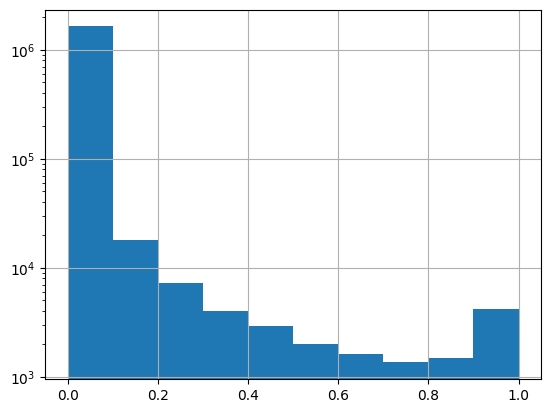

In [43]:
df['binds'].to_pandas().hist(log = True)

In [44]:
df.select(pl.col('id', 'binds')).write_csv('./catboost_12chunks.csv')